## Reinforcement Learning - Tetris

The current project is a heuristic model that uses a reward function with a greedy strategy to play Tetris. It was developed for the Reinformcement Learning course at FGV-EMAp. The students are:

- Bruno Lunardon
- George Dutra
- Zuilho Segundo

In [14]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import random
import torch
from IPython.display import clear_output
import cv2
from tetris import Tetris
import multiprocessing as mp
from skopt import gp_minimize
from skopt.space import Real
import seaborn as sns

In [2]:
OPT = {"width": 10, "height": 20, "block_size": 30, "fps": 300, "saved_path": "trained_models", "output": "output.mp4"}

In [3]:
def heuristic_game(w1,w2,w3,w4,opt,output_name=None):
    # Create the environment
    env = Tetris(width=opt["width"], height=opt["height"], block_size=opt["block_size"])
    env.reset()
    
    # Create the video writer if output_name is not None
    if output_name is not None:
        out = cv2.VideoWriter(output_name, cv2.VideoWriter_fourcc(*"MJPG"), opt["fps"],
                          (int(1.5*opt["width"]*opt["block_size"]), opt["height"]*opt["block_size"]))       
        render = True
    else:
        render = False

    while True:
        # Get the next states and actions
        next_steps = env.get_next_states()
        next_actions, _ = zip(*next_steps.items())
        
        # Stack all tensors to form a 2D tensor
        stacked_tensors = torch.stack(_)
        
        heuristic_scores = w1*stacked_tensors[:, 0]-w2*stacked_tensors[:, 1]-w3*stacked_tensors[:, 2]-w4*stacked_tensors[:, 3]
        # heuristic_scores = w1*linhas_limpa-w2*buracos-w3*rugosidade-w4*altura
        
        # Find the maximum of the scores
        max_score = torch.max(heuristic_scores)

        # Find the index of the tensor(s) with the maximum score
        indices = (heuristic_scores == max_score).nonzero(as_tuple=True)[0]
    
        # If there are multiple tensors with the same maximum score, choose one randomly
        random_index = random.randint(0, len(indices)-1)

        # Perform the next action
        _, done = env.step(next_actions[indices[random_index]], render=render,video=out)

        # If the game is done, break the loop
        if done:
            if output_name is not None:
                out.release()
                cv2.destroyAllWindows()
            break

    return env.cleared_lines

In [4]:
def heuristic_gameS(w1,w2,w3,w4,opt,M,output_name=None,render=False):
    
    # Create the environment
    env = Tetris(width=opt["width"], height=opt["height"], block_size=opt["block_size"])
    env.reset()
    
    sum_linhas = 0
    
    # Create the video writer if output_name is not None
    if output_name is not None:
        out = cv2.VideoWriter(output_name, cv2.VideoWriter_fourcc(*"MJPG"), opt["fps"],
                          (int(1.5*opt["width"]*opt["block_size"]), opt["height"]*opt["block_size"]))       
        render = True
    else:
        render = False

    # Play the game M times
    for i in range(M):
        while True:

            # Get the next states and actions
            next_steps = env.get_next_states()
            next_actions, _ = zip(*next_steps.items())
            
            # Stack all tensors to form a 2D tensor
            stacked_tensors = torch.stack(_)
            
            heuristic_scores = w1*stacked_tensors[:, 0]-w2*stacked_tensors[:, 1]-w3*stacked_tensors[:, 2]-w4*stacked_tensors[:, 3]
            #heuristic_scores = w1*linhas_limpa-w2*buracos-w3*rugosidade-w4*altura
            
            # Find the maximum of the scores
            max_score = torch.max(heuristic_scores)

            # Find the index of the tensor(s) with the maximum score
            indices = (heuristic_scores == max_score).nonzero(as_tuple=True)[0]
        
            # If there are multiple tensors with the same maximum score, choose one randomly
            random_index = random.choice(indices)

            # Perform the next action
            _, done = env.step(next_actions[indices[random_index]], render=render,video=out)

                
            if done:
                if output_name is not None:
                    out.release()
                    cv2.destroyAllWindows()
                break
        
        # Add the number of cleared lines to the sum
        sum_linhas += env.cleared_lines

        # Reset the environment for the next game
        env.reset()

    return sum_linhas/M

In [5]:
def objective(weights):
    opt = {"width": 10, "height": 20, "block_size": 30, "fps": 60, "saved_path": "trained_models", "output": "output.mp4"}
    w1,w2,w3,w4=weights
    return-heuristic_gameS(w1,w2,w3,w4,opt,50)
    
space = [Real(0, 1, name="w1"),
         Real(0, 1, name="w2"),
         Real(0, 1, name="w3"),
         Real(0, 1, name="w4")]

#result=gp_minimize(objective,space,n_calls=25,random_state=0, verbose=True,n_random_starts=10)


In [63]:
df=pd.read_csv('25pt_50g.csv')
arr=df.to_numpy()
ws=arr[:,0:4]
best_ws=arr[-1,0:4]
#heuristic_game(best_ws[0],best_ws[1],best_ws[2],best_ws[3],OPT,output_name="best.mp4")

In [18]:
print(df.tail())
print(best_ws)

          w1        w2        w3        w4     score  Game0  Game1  Game2  \
20  0.395352  0.537060  0.185634  0.731837   2952.80   6845    784   2272   
21  0.070973  0.537820  0.185484  0.732204   3087.54    721   7765    263   
22  0.000000  0.615927  0.196973  0.562095   3175.54    875   1776   2052   
23  0.037503  1.000000  0.257526  1.000000   3132.20   3235   8196   1249   
24  0.393570  1.000000  0.231162  0.051131  14549.06  16953  13357  12366   

    Game3  Game4  ...  Game40  Game41  Game42  Game43  Game44  Game45  Game46  \
20    605   9563  ...    7764     214     508    5235    1321    3297     169   
21   2888   5378  ...    2909    9047     772     519    1777    2833     450   
22   1577    280  ...    3202    3919    3265    6042    2013     192     497   
23   3178    418  ...    3345   15908     351     315    8926    2432    6611   
24  18760   2037  ...     185   27415    8962   24933   35590    1817   29370   

    Game47  Game48  Game49  
20    4498    2230   

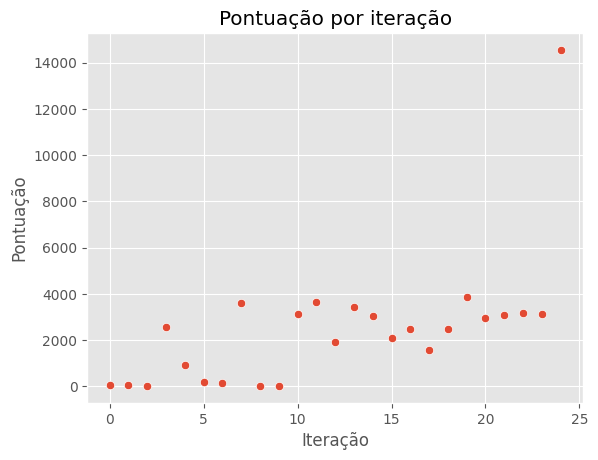

In [58]:
sns.scatterplot(x=np.arange(0,25),y=arr[:,4])
plt.xlabel('Iteração')
plt.ylabel('Pontuação')
plt.title('Pontuação por iteração')
plt.show()

C:\Users\lunar\AppData\Local\Temp\ipykernel_32188\858411878.py:15: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar=fig.colorbar(sc,ax=ax,orientation='vertical')


ConversionError: Failed to convert value(s) to axis units: 'off'

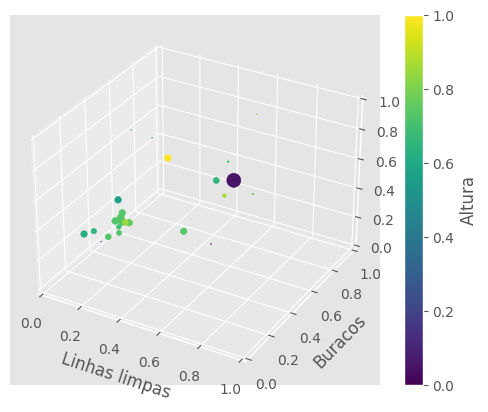

In [59]:
x = ws[:,0]
y = ws[:,1]
z = ws[:,2]
c = ws[:,3]
time=np.arange(0,25)
colors=cm.viridis(c)
sizes=arr[:,4]
sizes_norm=sizes/np.max(sizes)
sizes_scaled=sizes_norm*100

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

sc=ax.scatter(x, y, z,c=colors,s=sizes_scaled,depthshade=False)
cbar=fig.colorbar(sc,ax=ax,orientation='vertical')
cbar.set_label('Altura')


ax.set_xlabel('Linhas limpas')
ax.set_ylabel('Buracos')
ax.set_zlabel('Rugosidade')
ax.set_xlim3d(0,1)
ax.set_ylim3d(0,1)
ax.set_zlim3d(0,1)
ax.set_yticks("off")

plt.show()

C:\Users\lunar\AppData\Local\Temp\ipykernel_32188\341073960.py:7: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = fig.colorbar(sc, ax=ax, orientation='vertical', shrink=0.8, pad=0.1)


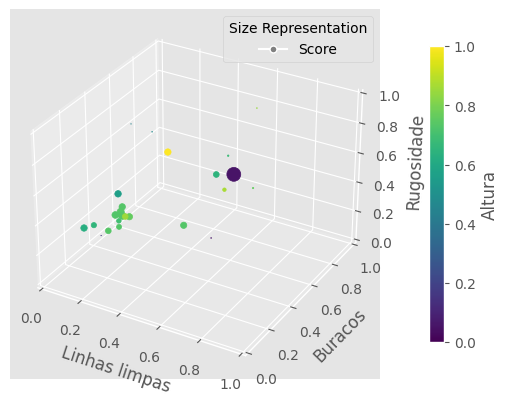

In [51]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

sc = ax.scatter(x, y, z, c=colors, s=sizes_scaled, depthshade=False)

# Colorbar adjustment to possibly prevent overlap
cbar = fig.colorbar(sc, ax=ax, orientation='vertical', shrink=0.8, pad=0.1)
cbar.set_label('Altura')

# Add a legend for size representation
# You can adjust these as per your data's min, max, and mean sizes for more clarity
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='gray', markersize=5),
           plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='gray', markersize=10),
           plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='gray', markersize=15)]
labels = ['Score']
ax.legend(handles, labels, title="Size Representation", loc="upper right")

ax.set_xlabel('Linhas limpas')
ax.set_ylabel('Buracos')
ax.set_zlabel('Rugosidade')
ax.set_xlim3d(0, 1)
ax.set_ylim3d(0, 1)
ax.set_zlim3d(0, 1)

plt.show()

In [68]:
df['média de linhas limpas']=df['score']
df[['w1','w2','w3','w4','média de linhas limpas']].iloc[10:]

,w1,w2,w3,w4,média de linhas limpas
10,0.008692,0.313882,0.166779,0.627822,3141.08
11,0.115619,0.468292,0.187301,0.733699,3637.40
12,0.186148,0.327664,0.236411,0.732568,1898.84
13,0.084470,0.457361,0.188927,0.727402,3421.70
14,0.138684,0.490014,0.175749,0.761136,3053.70
15,0.048265,0.334625,0.188059,0.652703,2096.38
16,0.129613,0.326801,0.187017,0.734783,2478.12
17,0.088138,0.480159,0.133075,0.698325,1579.92
18,0.129248,0.470109,0.187066,0.852142,2466.44
19,0.088882,0.495892,0.185907,0.735433,3846.50


In [82]:
dfpt=pd.read_csv('linhas_limpas1.csv')
arrpt=dfpt.to_numpy()
arrpt[:,1].std(ddof=1)

11945.569880558782

In [ ]:
tetris=Tetris()

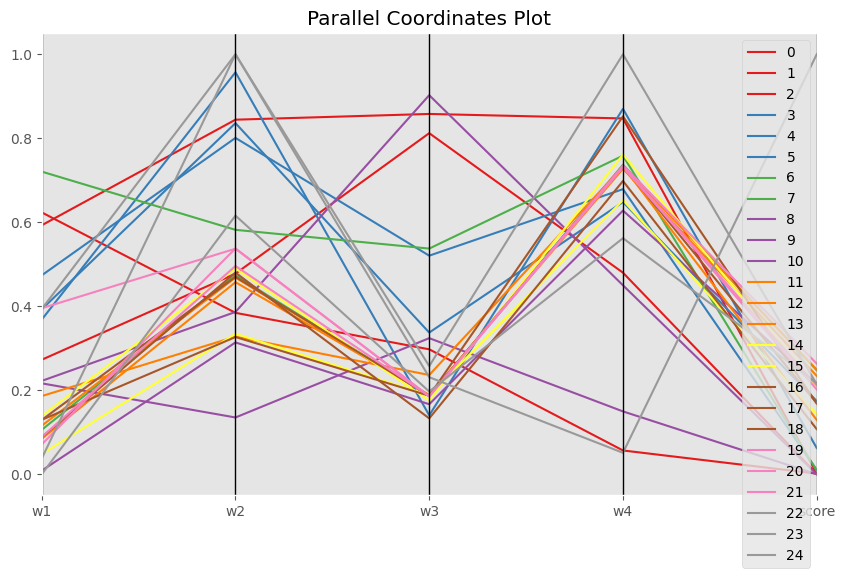

In [37]:
import pandas as pd
import matplotlib.pyplot as plt
from pandas.plotting import parallel_coordinates

# # Sample data
# data = {
#     'A': [1, 2, 3],
#     'B': [4, 5, 6],
#     'C': [7, 8, 9],
#     'D': [10, 11, 12],
#     'Category': ['a', 'b', 'c']
# }
# df2 = pd.DataFrame(data)
time=np.arange(0,25)
df['time']=time
#normalizar coluna score
df['score']=(df['score']-df['score'].min())/(df['score'].max()-df['score'].min())




# Plot
plt.figure(figsize=(10, 6))
parallel_coordinates(df[['w1','w2','w3','w4','time','score']], 'time', colormap=plt.get_cmap("Set1"))
plt.title("Parallel Coordinates Plot")
plt.show()


(25, 5)


ValueError: x and y must have same first dimension, but have shapes (6,) and (26, 5)

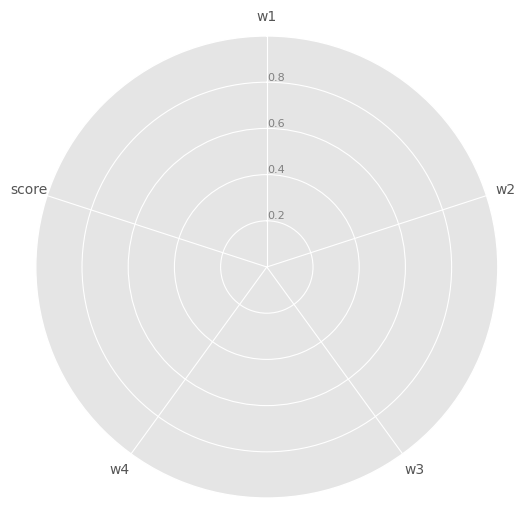

In [41]:
def create_radial_plot(data, features, title=""):
    # Number of variables
    N = len(features)

    # What will be the angle of each axis in the plot? (we divide the plot / number of variable)
    angles = [n / float(N) * 2 * np.pi for n in range(N)]
    angles += angles[:1]

    # Initialise the spider plot
    fig, ax = plt.subplots(figsize=(6, 6), subplot_kw={'projection': 'polar'})

    # If you want the first axis to be on top:
    ax.set_theta_offset(np.pi / 2)
    ax.set_theta_direction(-1)

    # Draw one axe per variable + add labels
    plt.xticks(angles[:-1], features)

    # Draw ylabels
    ax.set_rlabel_position(0)
    yticks = [0.2, 0.4, 0.6, 0.8]
    plt.yticks(yticks, [str(y) for y in yticks], color="grey", size=8)
    plt.ylim(0, 1)

    # Plot data
    values = data.tolist()
    values += values[:1]
    ax.plot(angles, values, linewidth=2, linestyle='solid')
    ax.fill(angles, values, alpha=0.4)

    plt.title(title)

    plt.show()

# Sample 4D data and features

data = arr[:,:5]  # Assume all data is normalized between 0 and 1
print(data.shape)
features = ["w1", "w2", "w3", "w4","score"]

create_radial_plot(data, features, title="Sample 5D Radial Plot")


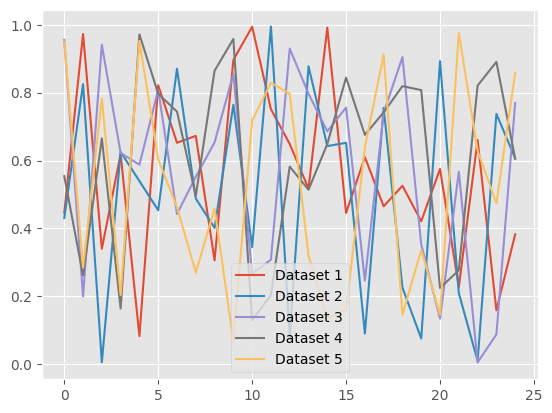

In [42]:
import numpy as np
import matplotlib.pyplot as plt

# Sample data
data = np.random.rand(25, 5)  # Replace with your data

# Create x values
x_values = np.arange(25)

# Plotting each of the 5 datasets
for i in range(5):
    plt.plot(x_values, data[:, i], label=f"Dataset {i+1}")

plt.legend()
plt.show()


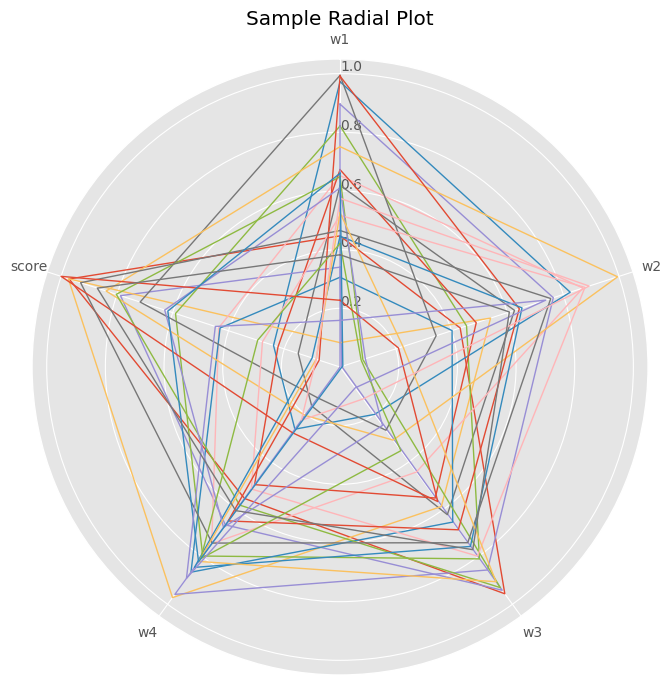

In [44]:
import numpy as np
import matplotlib.pyplot as plt

def create_radial_plot(data, title=""):
    # Number of variables (5 in your case)
    N = data.shape[1]
    angles = [n / float(N) * 2 * np.pi for n in range(N)]
    angles += angles[:1]  # repeat the first value to close the circle
    
    # Initialise the spider plot
    fig, ax = plt.subplots(figsize=(8, 8), nrows=1, ncols=1, subplot_kw={'projection': 'polar'})
    
    # If you want the first axis to be on top:
    ax.set_theta_offset(np.pi / 2)
    ax.set_theta_direction(-1)
    
    # Draw one axis per variable + add labels
    labels = ["w" + str(i+1) for i in range(N-1)]
    labels.append("score")
    plt.xticks(angles[:-1], labels)
    
    # Draw ylabels
    ax.set_rlabel_position(0)
    
    # Plot each data point
    for i in range(data.shape[0]):
        values = data[i, :].tolist()
        values += values[:1]
        ax.plot(angles, values, linewidth=1, linestyle='solid', label=f'Point {i+1}')
    
    plt.title(title)
    plt.show()

data[:,4]=(data[:,4]-data[:,4].min())/(data[:,4].max()-data[:,4].min())


create_radial_plot(data, title="Sample Radial Plot")
